# Client comparison
In this notebook, we will attempt to compare the performance of the different eth2 clients participating in the Medalla testnet. These clients are:
- [Prysm](https://github.com/prysmaticlabs/prysm) from [Prysmatic Labs](https://prysmaticlabs.com/)
- [Lighthouse](https://github.com/sigp/lighthouse) from [Sigma Prime](https://sigmaprime.io/)
- [Teku](https://github.com/PegaSysEng/teku) from [PegaSys](https://pegasys.tech/)
- [Nimbus](https://github.com/status-im/nimbus) from [Status.im](https://status.im/)
- [Lodestar](https://github.com/ChainSafe/lodestar) from [Chainsafe](https://chainsafe.io/)

There is no definitive way to identify which client software powers each validator — as long as a given client follows the protocol rules, it is equivalent to any other client from the perspective of the network. However, for the purposes of Medalla, many users chose to indicate what client they were using in the `graffiti` field in blocks they propose. Those aiming to collect [POAP non-fungible tokens (NFTs)](https://beaconcha.in/poap) will have set their validators to include a graffiti string indicating their eth1 deposit address, and ending with a letter A, B, C, D or E, corresponding to the Prysm, Lighthouse, Teku, Nimbus and Lodestar clients respectively. For example, the third block in the dataset has the graffiti `poapg4eM7/cwRi/ZhaZg0zp6b9A6JlcA` indicating the block was produced by the Prysm client. Other validators have included the full name of their client in the graffiti — the very next block includes the graffiti `Lighthouse/v0.2.0/f26adc0a`. It seems a reasonable guess that this block was produced by the Lighthouse client.

Of course, the graffiti field can be set to whatever the user running the validator chooses, including misleading information about the client being used. For the most part there is little reason to expect users would not be honest, with the exception that some may have chosen to game the POAP system to collect NTFs for all clients without the hassle of actually installing and using them. Nonetheless, to make progress with our analysis we will need to assume that the majority of validators were honest. Where we have large numbers of validators indicating the use of a certain client therefore, we might expect to gain  some insight into how that client has performed in aggregate. We may need to be a little more cautious if there are clients with a very small number of validators indicating participation through their beacon chain graffiti.

For the purposes of this analysis, we will assume that any validator which consistently indicates a particular client through its graffiti is genuinely running the claimed client. Validators which appear to switch clients, or which refer to mulitple clients in their graffiti, will be excluded (NB This will exclude even users who genuinely have switched clients, since validators produce blocks only occasionally, and it would be impossible to know exactly when they switched).

In [1]:
# imports
import psycopg2
import math
import time
import matplotlib.pyplot as plt
import pandas as pd

from chaindtools import *

In [2]:
# open/restart connection to chaind database
try:
    cursor.close()
    connection.close()
except:
    pass

connection = psycopg2.connect(user="chain", host="127.0.0.1", database="chain", password="medalla")
cursor = connection.cursor()

First, we restore some variables saved in the previous notebook to avoid recalculating them.

In [3]:
%store -r validators n_epochs latest_slot

## Client proportions
It turns out that the majority of validators (71%) did not provide information in block graffiti which could be used to identify the client used. This includes all validators which did not propose any blocks, since graffiti is only supplied by the block producer. For this reason, validators who were *absent* or those which did not participate long enough to propose any blocks, are excluded.

Number of validators: 73258
20866 provided client info (28.5%)
33520 no info (45.8%)
18872 no blocks produced (25.8%)


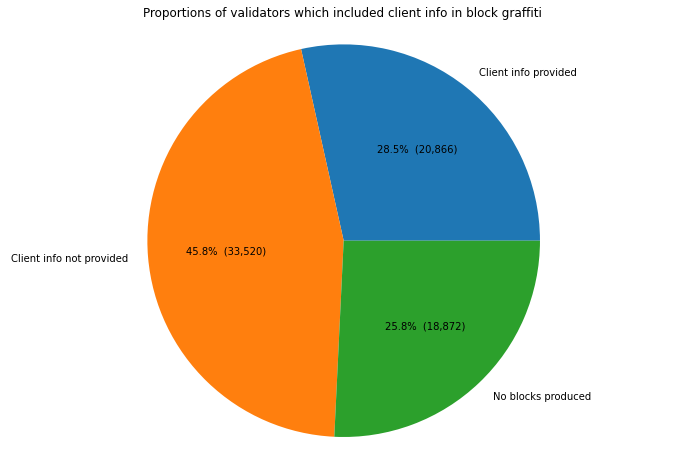

Number of validators providing client info: 20866
 9874 Prysm (47.3%)
 5928 Lighthouse (28.4%)
 1878 Teku (9.0%)
 1381 Nimbus (6.6%)
   36 Lodestar (0.2%)
 1769 ambiguous (8.5%)


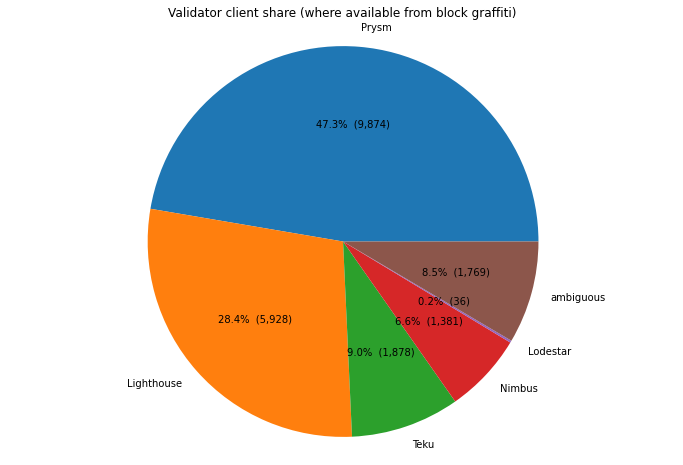

In [4]:
# determine validator clients from block graffiti

cursor.execute(f"SELECT f_proposer_index, f_graffiti FROM t_blocks WHERE f_canonical = true")
proposers = cursor.fetchall()

for _, validator in validators.items():
    validator["client"] = ""
    validator["producer"] = False

for proposer in proposers:
    validator = validators[proposer[0]]
    validator["producer"] = True
    graffiti = proposer[1].tobytes().decode(errors='ignore').lower()
    
    if validator["client"] == "ambiguous":
        continue
    
    pr_flag = 1 if (graffiti[:4] == "poap" and graffiti[-1] == "a") or graffiti.find("prysm") != -1 else 0
    li_flag = 1 if (graffiti[:4] == "poap" and graffiti[-1] == "b") or graffiti.find("lighthouse") != -1 else 0
    te_flag = 1 if (graffiti[:4] == "poap" and graffiti[-1] == "c") or graffiti.find("teku") != -1 else 0
    ni_flag = 1 if (graffiti[:4] == "poap" and graffiti[-1] == "d") or graffiti.find("nimbus") != -1 else 0
    lo_flag = 1 if (graffiti[:4] == "poap" and graffiti[-1] == "e") or graffiti.find("lodestar") != -1 else 0
    n_flags = pr_flag + li_flag + te_flag + ni_flag + lo_flag
    
    if n_flags > 1:
        validator["client"] = "ambiguous"
    elif pr_flag:
        validator["client"] = "prysm" if validator["client"] in ["", "prysm"] else "ambiguous"
    elif li_flag:
        validator["client"] = "lighthouse" if validator["client"] in ["", "lighthouse"] else "ambiguous"
    elif te_flag:
        validator["client"] = "teku" if validator["client"] in ["", "teku"] else "ambiguous"
    elif ni_flag:
        validator["client"] = "nimbus" if validator["client"] in ["", "nimbus"] else "ambiguous"
    elif lo_flag:
        validator["client"] = "lodestar" if validator["client"] in ["", "lodestar"] else "ambiguous"

pr_count = li_count = te_count = ni_count = lo_count = amb_count = 0
for _, validator in validators.items():
    if validator["client"] == "prysm":
        pr_count += 1
    elif validator["client"] == "lighthouse":
        li_count += 1
    elif validator["client"] == "teku":
        te_count += 1
    elif validator["client"] == "nimbus":
        ni_count += 1
    elif validator["client"] == "lodestar":
        lo_count += 1
    elif validator["client"] == "ambiguous":
        amb_count += 1

no_blocks_count = sum(not v["producer"] for _, v in validators.items())
no_info_count = sum(v["client"] == "" for _, v in validators.items()) - no_blocks_count
client_info_count = len(validators) - no_blocks_count - no_info_count

print(f"Number of validators: {len(validators)}")
print(f"{client_info_count:5} provided client info ({100*client_info_count/len(validators):.1f}%)")
print(f"{no_info_count:5} no info ({100*no_info_count/len(validators):.1f}%)")
print(f"{no_blocks_count:5} no blocks produced ({100*no_blocks_count/len(validators):.1f}%)")

labels = ['Client info provided', 'Client info not provided', 'No blocks produced']
counts = [client_info_count, no_info_count, no_blocks_count]
fig0, ax0 = plt.subplots(figsize=(12,8))
ax0.pie(counts, labels=labels, autopct=lambda p: f"{p:.1f}%  ({p * sum(counts)/100:,.0f})")
ax0.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportions of validators which included client info in block graffiti')
plt.show()

print(f"Number of validators providing client info: {client_info_count}")
print(f"{pr_count:5} Prysm ({     100*pr_count  / client_info_count:.1f}%)")
print(f"{li_count:5} Lighthouse ({100*li_count  / client_info_count:.1f}%)")
print(f"{te_count:5} Teku ({      100*te_count  / client_info_count:.1f}%)")
print(f"{ni_count:5} Nimbus ({    100*ni_count  / client_info_count:.1f}%)")
print(f"{lo_count:5} Lodestar ({  100*lo_count  / client_info_count:.1f}%)")
print(f"{amb_count:5} ambiguous ({100*amb_count / client_info_count:.1f}%)")

labels = ['Prysm', 'Lighthouse', 'Teku', 'Nimbus', 'Lodestar', 'ambiguous']
counts = [pr_count, li_count, te_count, ni_count, lo_count, amb_count]
fig1, ax1 = plt.subplots(figsize=(12,8))
ax1.pie(counts, labels=labels, autopct=lambda p: f"{p:.1f}%  ({p * sum(counts)/100:,.0f})")
ax1.axis('equal')
plt.title('Validator client share (where available from block graffiti)')
plt.show()

In [5]:
# calculate participation rates, mean inclusion distance and attestation effectiveness for each client
# if the attestation is missed and the validator has not yet done any attestations, it is considered dormant
# if the attestation is missed and there are no future attestations, it is considered abandoned

start_time = time.time()

empty = [0] * n_epochs
clients = ["prysm", "lighthouse", "teku", "nimbus"]
success_count   = {client:empty.copy() for client in clients}
absent_count    = {client:empty.copy() for client in clients}
dormant_count   = {client:empty.copy() for client in clients}
abandoned_count = {client:empty.copy() for client in clients}
missed_count    = {client:empty.copy() for client in clients}
sum_distance    = {client:empty.copy() for client in clients}
sum_ae          = {client:empty.copy() for client in clients}

for slot in range(latest_slot+1):
    validator_scores, validator_ae = attestation_performance(cursor, slot)
    epoch = slot // 32
    for validator_index in validator_scores:
        client = validators[validator_index]["client"]
        if client not in clients:
            continue
        if validator_scores[validator_index] != -1:
            success_count[client][epoch]   += 1
            sum_distance[client][epoch]    += validator_scores[validator_index]
            sum_ae[client][epoch]          += validator_ae[validator_index]
        elif validators[validator_index]["latest_attestation"] == -1:
            absent_count[client][epoch]    += 1
        elif slot < validators[validator_index]["first_attestation"]:
            dormant_count[client][epoch]   += 1
        elif slot > validators[validator_index]["latest_attestation"]:
            abandoned_count[client][epoch] += 1
        else:
            missed_count[client][epoch]    += 1

    seconds = time.time() - start_time
    elapsed = time.strftime("%H:%M:%S",time.gmtime(seconds))
    left = time.strftime("%H:%M:%S",time.gmtime(seconds * ((latest_slot+1) / (slot+1)-1)))
    percentage = 100*(slot+1)/(latest_slot+1)
    print(f"Epoch {epoch} of {latest_slot//32} ({percentage:.2f}%). "
          f"{elapsed} elapsed. {left} left.", end='\r')

mean_inclusion_distance = {}
attestation_effectiveness = {}
for client in clients:
    mean_inclusion_distance[client] = [sum_distance[client][e] / success_count[client][e] 
                                       if success_count[client][e] > 0 else None for e in range(n_epochs)]
    attestation_effectiveness[client] = [100 * sum_ae[client][e] / 
                                                          (success_count[client][e] + missed_count[client][e])
                                        for e in range(n_epochs)]
    
print(f"Pass completed in {elapsed}." + ' ' * 50)

Pass completed in 00:43:59.                                                  


## Participation rate
Let's have a look at how the participation rates for the different clients compare. As in the previous notebook, we're going to ignore *dormant* and *abandoned* validators. As mentioned above, *absent* validators are already excluded from this dataset. Also, given the very low number of validators self-identifying as Lodestar, this client will be excluded from the remaining analysis, since any results from such a small sample would be unreliable.

The lines below have also been smoothed with a 16-epoch moving average, as they are a bit too fuzzy to compare between clients otherwise.

              prysm    lighthouse          teku        nimbus
count  12148.000000  12148.000000  12148.000000  12148.000000
mean      86.618789     73.480409     84.353031     42.406944
std       23.988400     26.908286     23.153159     30.994028
min        0.000000      0.000000      0.000000      0.000000
25%       90.653092     54.140838     87.214612     20.760456
50%       94.483592     87.389618     90.924756     36.421516
75%       97.254317     94.869119     94.131925     69.572482
max      100.000000    100.000000    100.000000    100.000000


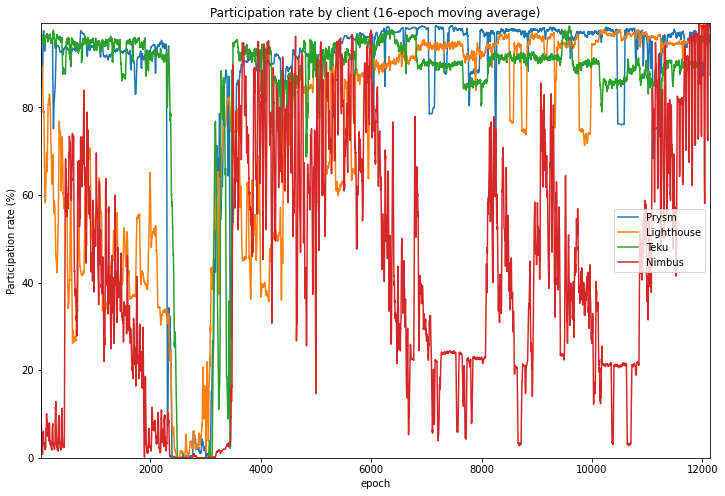

             prysm   lighthouse         teku       nimbus
count  7148.000000  7148.000000  7148.000000  7148.000000
mean     94.869432    90.968935    90.520153    47.470087
std       5.596469     8.516688     4.561454    28.502589
min      64.829932    54.814996    18.563300     1.387818
25%      95.252710    90.186942    87.934134    22.571001
50%      96.925886    94.032936    90.811117    41.088003
75%      97.879056    95.795975    93.426659    72.678574
max     100.000000   100.000000   100.000000   100.000000


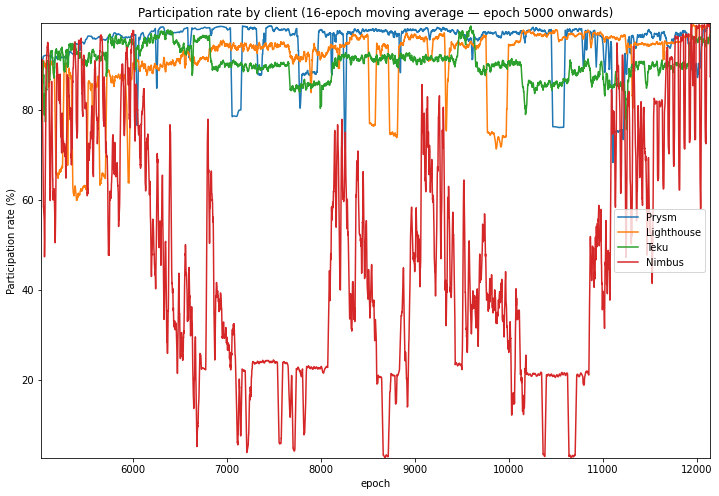

In [6]:
# calculate/describe/plot participation rates by client
participation_rate = {}
for client in clients:
    participation_rate[client] = [100* success_count[client][e] /
                                  (success_count[client][e] + missed_count[client][e]) for e in range(n_epochs)]

participation_rate_df = pd.DataFrame(participation_rate)

print(participation_rate_df.describe())

# plot the participation rate
fig=plt.figure(figsize=(12,8))
plt.plot(participation_rate_df['prysm'].rolling(16).mean(), label='Prysm')
plt.plot(participation_rate_df['lighthouse'].rolling(16).mean(), label='Lighthouse')
plt.plot(participation_rate_df['teku'].rolling(16).mean(), label='Teku')
plt.plot(participation_rate_df['nimbus'].rolling(16).mean(), label='Nimbus')
plt.legend(loc='right')
plt.margins(0,0)
plt.title('Participation rate by client (16-epoch moving average)')
plt.xlabel('epoch')
plt.ylabel('Participation rate (%)')
plt.show()

# stats for epoch 5000 onwards
print(participation_rate_df.iloc[5000:].describe())

# plot the participation rate for epoch 5000 onwards
fig=plt.figure(figsize=(12,8))
plt.plot(participation_rate_df['prysm'].iloc[5000:].rolling(16).mean(), label='Prysm')
plt.plot(participation_rate_df['lighthouse'].iloc[5000:].rolling(16).mean(), label='Lighthouse')
plt.plot(participation_rate_df['teku'].iloc[5000:].rolling(16).mean(), label='Teku')
plt.plot(participation_rate_df['nimbus'].iloc[5000:].rolling(16).mean(), label='Nimbus')
plt.legend(loc='right')
plt.margins(0,0)
plt.title('Participation rate by client (16-epoch moving average — epoch 5000 onwards)')
plt.xlabel('epoch')
plt.ylabel('Participation rate (%)')
plt.show()

## Mean inclusion distance
Let's repeat the plot of mean inclusion distance we previously saw for the network as a whole, this time, broken down by client. Again the data is smoothed with a 16-epoch moving average to make it easier to see what's going on.

Mean inclusion distance statistics

              prysm    lighthouse          teku        nimbus
count  12024.000000  12056.000000  11649.000000  11429.000000
mean       1.190256      1.200255      0.913062      0.968886
std        3.117934      3.233582      2.078713      1.577799
min        0.000000      0.000000      0.000000      0.000000
25%        0.294591      0.254208      0.300823      0.348817
50%        0.415436      0.365517      0.476190      0.554890
75%        0.591695      0.546919      0.788916      1.005814
max       29.400000     31.000000     31.000000     31.000000



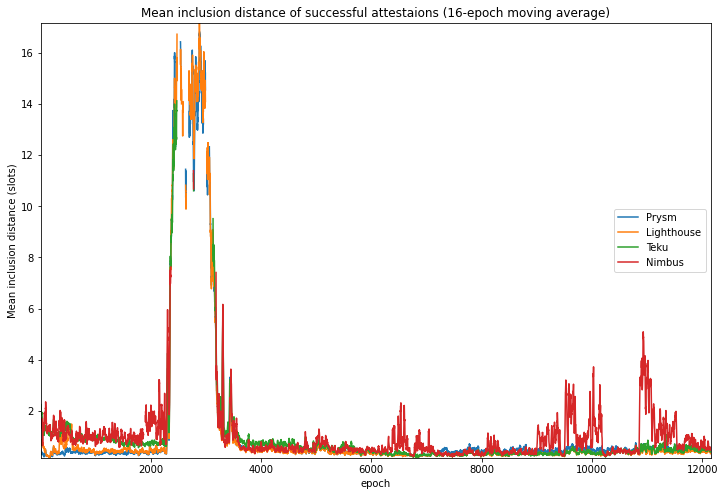

Mean inclusion distance statistics

             prysm   lighthouse         teku       nimbus
count  7148.000000  7148.000000  7148.000000  7148.000000
mean      0.433759     0.347997     0.391211     0.754577
std       0.211240     0.194428     0.229255     0.871204
min       0.000000     0.000000     0.000000     0.000000
25%       0.290872     0.222295     0.241283     0.300699
50%       0.400413     0.307788     0.342744     0.463786
75%       0.534415     0.427583     0.477571     0.795060
max       2.825568     2.735209     3.458170     9.770270



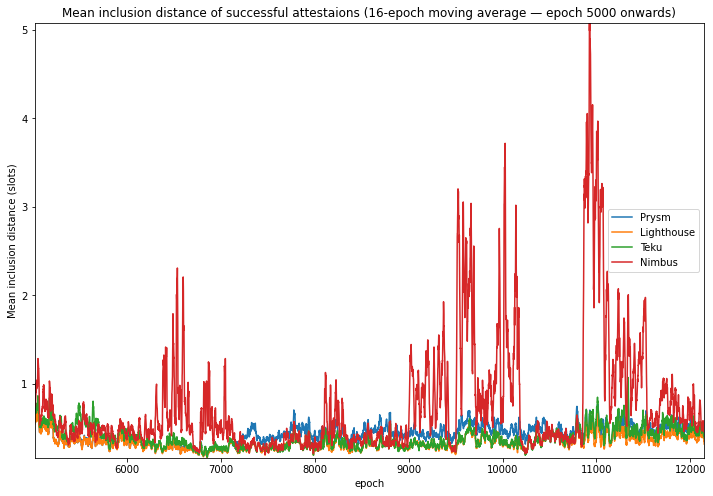

In [7]:
# graphs and stats for mean inclusion distance
mid_df = pd.DataFrame.from_dict(mean_inclusion_distance)

print("Mean inclusion distance statistics\n")
print(mid_df.describe(), end='\n\n')

# plot the mean inclusion distance
fig=plt.figure(figsize=(12,8))
plt.plot(mid_df['prysm'].rolling(16).mean(), label='Prysm')
plt.plot(mid_df['lighthouse'].rolling(16).mean(), label='Lighthouse')
plt.plot(mid_df['teku'].rolling(16).mean(), label='Teku')
plt.plot(mid_df['nimbus'].rolling(16).mean(), label='Nimbus')
plt.legend(loc='right')
plt.margins(0,0)
plt.title('Mean inclusion distance of successful attestaions (16-epoch moving average)')
plt.xlabel('epoch')
plt.ylabel('Mean inclusion distance (slots)')
plt.show()

print("Mean inclusion distance statistics\n")
print(mid_df.iloc[5000:].describe(), end='\n\n')

# plot the mean inclusion distance
fig=plt.figure(figsize=(12,8))
plt.plot(mid_df['prysm'].iloc[5000:].rolling(16).mean(), label='Prysm')
plt.plot(mid_df['lighthouse'].iloc[5000:].rolling(16).mean(), label='Lighthouse')
plt.plot(mid_df['teku'].iloc[5000:].rolling(16).mean(), label='Teku')
plt.plot(mid_df['nimbus'].iloc[5000:].rolling(16).mean(), label='Nimbus')
plt.legend(loc='right')
plt.margins(0,0)
plt.title('Mean inclusion distance of successful attestaions (16-epoch moving average — epoch 5000 onwards)')
plt.xlabel('epoch')
plt.ylabel('Mean inclusion distance (slots)')
plt.show()

## Attestation effectiveness

Attestation Effectiveness statistics

              prysm    lighthouse          teku        nimbus
count  12148.000000  12148.000000  12148.000000  12148.000000
mean      84.418044     71.396174     78.132838     38.747971
std       24.218949     27.391964     23.379311     28.980684
min        0.000000      0.000000      0.000000      0.000000
25%       87.975446     51.515024     78.682510     19.486736
50%       92.375678     85.601533     85.635355     32.166045
75%       95.452075     92.847489     90.045804     63.403307
max      100.000000    100.000000    100.000000    100.000000



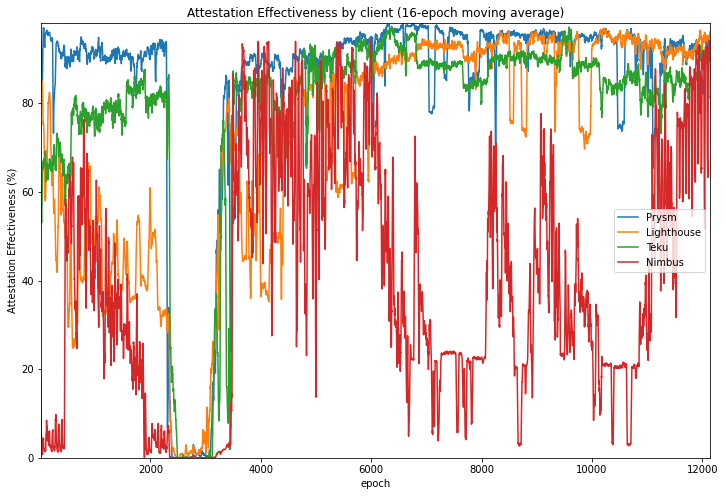

Attestation Effectiveness statistics (epoch 5000 onwards)

             prysm   lighthouse         teku       nimbus
count  7148.000000  7148.000000  7148.000000  7148.000000
mean     92.697762    89.308731    88.304858    43.191903
std       5.848948     8.487680     5.231368    26.129749
min      58.851676    52.248713    15.472269     1.387818
25%      91.649929    88.318804    85.502193    21.965030
50%      94.798371    92.163133    88.834861    34.566204
75%      96.258340    94.529452    91.497400    66.066254
max     100.000000   100.000000   100.000000   100.000000



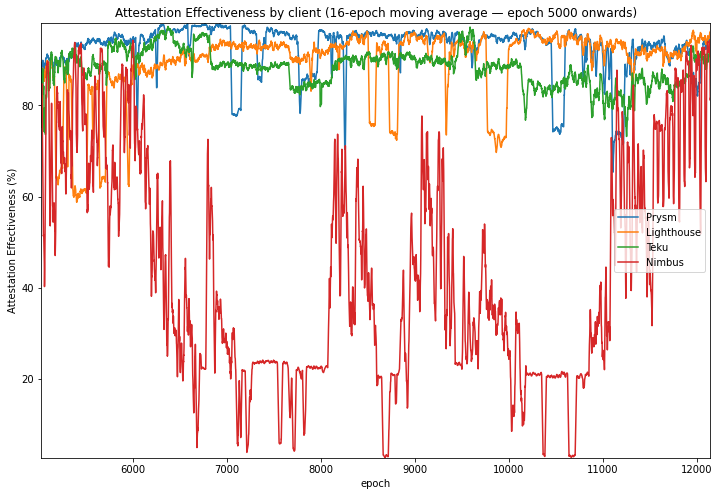

In [8]:
# graphs and stats for attestation effectiveness
ae_df = pd.DataFrame.from_dict(attestation_effectiveness)

print("Attestation Effectiveness statistics\n")
print(ae_df.describe(), end='\n\n')

# plot the mean inclusion distance
fig=plt.figure(figsize=(12,8))
plt.plot(ae_df['prysm'].rolling(16).mean(), label='Prysm')
plt.plot(ae_df['lighthouse'].rolling(16).mean(), label='Lighthouse')
plt.plot(ae_df['teku'].rolling(16).mean(), label='Teku')
plt.plot(ae_df['nimbus'].rolling(16).mean(), label='Nimbus')
plt.legend(loc='right')
plt.margins(0,0)
plt.title('Attestation Effectiveness by client (16-epoch moving average)')
plt.xlabel('epoch')
plt.ylabel('Attestation Effectiveness (%)')
plt.show()

print("Attestation Effectiveness statistics (epoch 5000 onwards)\n")
print(ae_df.iloc[5000:].describe(), end='\n\n')

# plot the mean inclusion distance
fig=plt.figure(figsize=(12,8))
plt.plot(ae_df['prysm'].iloc[5000:].rolling(16).mean(), label='Prysm')
plt.plot(ae_df['lighthouse'].iloc[5000:].rolling(16).mean(), label='Lighthouse')
plt.plot(ae_df['teku'].iloc[5000:].rolling(16).mean(), label='Teku')
plt.plot(ae_df['nimbus'].iloc[5000:].rolling(16).mean(), label='Nimbus')
plt.legend(loc='right')
plt.margins(0,0)
plt.title('Attestation Effectiveness by client (16-epoch moving average — epoch 5000 onwards)')
plt.xlabel('epoch')
plt.ylabel('Attestation Effectiveness (%)')
plt.show()